# Generate SMILES with the trained BART model
- explore the generating process, 
- find out why the huggingface's generate function acts weird
- look at BEAM SEARCH
- all the rest from NOTES

## Initialization

In [12]:
# imports
import os,sys,inspect, io
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import torch
import numpy as np
from transformers import BartForConditionalGeneration
import re

# custom veci
from dataset import SpectroDataset, SpectroDataCollator
sys.path.append('data')
sys.path.append('bart_spektro')
from modeling_bart_spektro import BartSpektoForConditionalGeneration
from configuration_bart_spektro import BartSpektroConfig
from data_preprocess1 import print_args
from bart_spektro_tokenizer import BartSpektroTokenizer
from tokenizers import Tokenizer


In [13]:
# silent environment (no prints)
import contextlib
@contextlib.contextmanager
def silence():
    sys.stdout, old = io.StringIO(), sys.stdout
    try:
        yield
    finally:
        sys.stdout = old

In [14]:
# DATA loading
data_type = "8M"
tokenizer_type = "_bbpe_1M" # ""
# test_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
# train_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'
test_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
train_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'

test_data = SpectroDataset(test_data_path, original=False, gen_mode=False)
# train_data = SpectroDataset(train_data_path, original=False, gen_mode=False)

In [18]:
# MODEL loading
if tokenizer_type:
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-21-14_51_12_2xA100/checkpoint-3460'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-01-09_52_21_bbpe1M_IDs/checkpoint-6920/'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-22-20_54_40_4xA40_ga4/checkpoint-6920/'
    model_path = f'./models/bart_2022-06-28-10_02_31_bigdata/checkpoint-72512/'
    checkpoint_num = "".join(re.findall('\d+', model_path.split("-")[-1]))  # extracted checkpoint number
else:
    model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-05-10-16_06_04_P_IDs/checkpoint-6920/'
    
    
model = BartSpektoForConditionalGeneration.from_pretrained(model_path)

# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

# TOKENIZER loading
if tokenizer_type:
    tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
    tokenizer = Tokenizer.from_file(tok)
else:
    with silence():
        tokenizer = BartSpektroTokenizer().init_tokenizer()

In [19]:
# change configs
if tokenizer_type:
    model.config.eos_token_id = 0
    model.config.bos_token_id = 3
    model.config.pad_token_id = 2
    model.config.decoder_start_token_id = 3
    model.config.forced_eos_token_id = 0
else: 
    model.config.eos_token_id = 502
    model.config.bos_token_id = 503
    model.config.pad_token_id = 501
    model.config.decoder_start_token_id = 503
    model.config.forced_eos_token_id = 502
    
model.config.max_length = 200
model.config.min_length = 0
#########################

In [20]:
test_data.data.head(3)

,destereo_smiles,input_ids,decoder_input_ids,encoder_attention_mask,decoder_attention_mask,labels,position_ids
0,FC(c1ccc2n(c1)c(N)cn2)(F)F,"[14, 19, 25, 26, 27, 28, 31, 33, 36, 37, 38, 3...","[3, 224, 495, 11, 70, 20, 280, 21, 81, 11, 70,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 495, 11, 70, 20, 280, 21, 81, 11, 70,...","[1, 1, 2, 4, 3, 5, 3, 1, 0, 5, 6, 7, 6, 7, 6, ..."
1,NC(=O)c1n[nH]c(c1)c1cccnc1,"[29, 30, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[3, 224, 265, 260, 50, 12, 70, 20, 81, 62, 277...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 265, 260, 50, 12, 70, 20, 81, 62, 277...","[0, 5, 1, 5, 6, 7, 6, 6, 4, 2, 7, 0, 1, 7, 7, ..."
2,CCc1ccc2c(c1Br)ccnc2,"[26, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[3, 224, 303, 20, 280, 21, 70, 11, 70, 20, 466...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 303, 20, 280, 21, 70, 11, 70, 20, 466...","[4, 4, 1, 6, 6, 7, 5, 6, 4, 6, 6, 2, 0, 6, 8, ..."


## Playing with generation
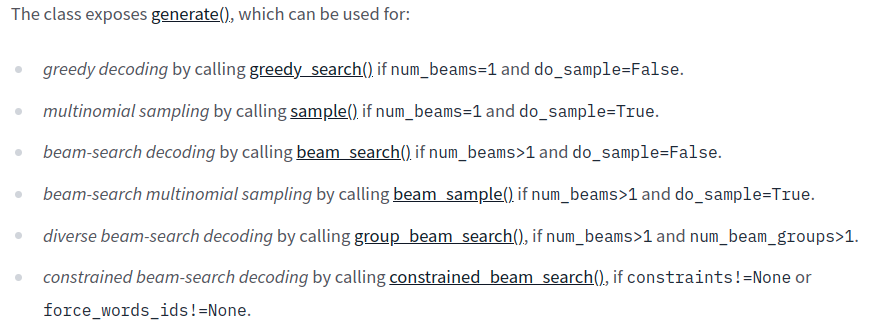

In [21]:
def generate_smiles(inputs, top_k=200, top_p=0.8, do_sample=True, num_beams=1, temperature=1, model=model):
    with torch.no_grad():
#         outputs = model(input_ids = inputs["input_ids"].unsqueeze(0).to(device=device), 
#                         position_ids = inputs["position_ids"].unsqueeze(0).to(device=device),
#                         labels = inputs["labels"].unsqueeze(0).to(device=device))
        generated = model.generate(
                       input_ids=inputs["input_ids"].unsqueeze(0).to(device=device), 
                       position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                       top_p=top_p,
                       top_k=top_k,
    #                    min_length=20,
    #                    max_length=200,
                       do_sample=do_sample,
                       num_beams=num_beams,
                       temperature=temperature
                       ).tolist()[0]
        return inputs, generated

In [8]:
inputs, generated = generate_smiles(test_data[300])

                                                       
                            ############ PRINTING #############
# GROUND TRUTH
print("##### GROUND TRUTH #####")
x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
if tokenizer_type:
    gt_smiles = tokenizer.decode(x)
    print("ground truth SMILES:", gt_smiles, "\n")
else:
    print("ground truth SMILES:", tokenizer.ids_to_smiles(x[x>0]), "\n")
print("ground truth ids:", x[x>0], "\n")
# print("mask:", inputs["decoder_attention_mask"].tolist(), "\n\n")

# GENERATED
print("##### GENERATED #####")
if tokenizer_type:
    print("generated:", tokenizer.decode(generated), "\n")
else:
    print("generated SMILES:", tokenizer.ids_to_smiles(generated), "\n")
print("generated ids:", generated, "\n")

# LOSSES
# print("##### LOSSES #####")
# print(f"loss: {outputs.loss}")
# print(f"logit bos: {outputs.logits[0][68][503].cpu().numpy()}")

##### GROUND TRUTH #####
ground truth SMILES:  CC1(N)COC1 

ground truth ids: [  3 224 261  20  11  49  12 285  20] 

##### GENERATED #####
generated:  CC(CN)(C)C 

generated ids: [3, 3, 224, 261, 11, 263, 289, 38, 12, 38, 0] 



/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [10]:
# sorted(tokenizer.get_vocab().items(), key=lambda x: x[1])

[('<eos>', 0),
 ('<ukn>', 1),
 ('<pad>', 2),
 ('<bos>', 3),
 ('!', 4),
 ('"', 5),
 ('#', 6),
 ('$', 7),
 ('%', 8),
 ('&', 9),
 ("'", 10),
 ('(', 11),
 (')', 12),
 ('*', 13),
 ('+', 14),
 (',', 15),
 ('-', 16),
 ('.', 17),
 ('/', 18),
 ('0', 19),
 ('1', 20),
 ('2', 21),
 ('3', 22),
 ('4', 23),
 ('5', 24),
 ('6', 25),
 ('7', 26),
 ('8', 27),
 ('9', 28),
 (':', 29),
 (';', 30),
 ('<', 31),
 ('=', 32),
 ('>', 33),
 ('?', 34),
 ('@', 35),
 ('A', 36),
 ('B', 37),
 ('C', 38),
 ('D', 39),
 ('E', 40),
 ('F', 41),
 ('G', 42),
 ('H', 43),
 ('I', 44),
 ('J', 45),
 ('K', 46),
 ('L', 47),
 ('M', 48),
 ('N', 49),
 ('O', 50),
 ('P', 51),
 ('Q', 52),
 ('R', 53),
 ('S', 54),
 ('T', 55),
 ('U', 56),
 ('V', 57),
 ('W', 58),
 ('X', 59),
 ('Y', 60),
 ('Z', 61),
 ('[', 62),
 ('\\', 63),
 (']', 64),
 ('^', 65),
 ('_', 66),
 ('`', 67),
 ('a', 68),
 ('b', 69),
 ('c', 70),
 ('d', 71),
 ('e', 72),
 ('f', 73),
 ('g', 74),
 ('h', 75),
 ('i', 76),
 ('j', 77),
 ('k', 78),
 ('l', 79),
 ('m', 80),
 ('n', 81),
 ('o', 82

## Inference / Evaluation
- COMMON PHASE
- generate 100 (?1000) SMILES
- remove redundancy
- filter the invalid ones <br>
=> Tanimoto wit the ground truth
    
 

   
## Extended inference
- OPTION 1
    - with NEIMS generate spektra
    - compare with original one (weighted CS)
    - sort according to the similarity
- OPTION 2 (~ VAE-search)
    - take the best predicted MOLECULE
    - encode it using VAE into a LATENT SPACE representation
    - do slight changes to this representation
    - generate SMILESs again
    - filter invalid ones (99.9%)          

### Common phase
- generate 100 (?1000) SMILES
- remove redundancy (not during evaluation)
- filter the invalid ones <br>
=> Tanimoto wit the ground truth
    


In [27]:
%%time
from pandas import Series, DataFrame
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from IPython.display import HTML

#topk=200
#topp=0.8
def evaluate_datapoint(inputs, num_generated=10, return_best=3, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
#     inputs = dat~a[id_]
    if tokenizer_type:
        gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
    else:
        x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
        gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
    generated_smiless = []
    
#     # generate
#     for _ in range(num_generated):
#         _, generated = generate_smiles(inputs, top_k=top_k, top_p=top_p, do_sample=do_sample, num_beams=num_beams, temperature=temperature)
#         if tokenizer_type:
#             generated_smiless.append(tokenizer.decode(generated[1:-1]))
#         else:
#             generated_smiless.append(tokenizer.ids_to_smiles(generated[1:-1]))
        # generate
    input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
    generated_outputs = model.generate(
                           input_ids=input_ids,
                           num_return_sequences = num_generated,
                           position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                           top_p=top_p,
                           top_k=top_k,
        #                    min_length=20,
        #                    max_length=200,
                           do_sample=do_sample,
                           num_beams=num_beams,
                           temperature=temperature,
                           return_dict_in_generate=True,
                           output_scores=False)

    # decode the generated SMILESs
    generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
    
    
    # deduplicate
    unique_smiless = np.unique(np.array(generated_smiless)) # generated_smiless # np.unique(np.array(generated_smiless)) #####################################
    
    # filter invalid
    valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]
    
    # compute similarity
    ms = [Chem.MolFromSmiles(smiles) for smiles in valid_smiless]
    gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
    fps = [Chem.RDKFingerprint(x) for x in ms if x]
    simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]
    smile_simil = list(zip(valid_smiless,simils))
    smile_simil.sort(key=lambda x: x[1], reverse=True)
    if printing == True:
        print("ground truth SMILES:", gt_smiles, "\n") ############################################
        print("num of uniques:", len(unique_smiless)) ##############################################
        print(smile_simil) #################################################################
        print("\n\nThe best:", smile_simil[0]) if smile_simil else print("\n\nNo suitable candidates :(") ###########################
    
#     df = DataFrame({"SMILES": valid_smiless, "molecule": ms, "similarity": simils}).sort_values(by="similarity", ascending=False)
#     return df
    result = sorted(simils, reverse=True)[:return_best]
    if len(result) < return_best:
        result = result + [0]*(return_best-len(result))
    return result

evaluate_datapoint(test_data[455]) #908

ground truth SMILES:  OC(=O)Cc1c(C)[nH]c2n(c1=O)ncc2 

num of uniques: 6
[(' OC(=O)Cc1cc(=O)nc2n1cccc2O', 0.38461538461538464), (' OC(=O)Cc1nnc2n1c(C)c(c(n2)C)C', 0.3278008298755187), (' Cc1ccn2c(n1)c(nc2O)CC(=O)O', 0.3181818181818182), (' OC(=O)Cc1ncc2c(n1)CCNC2=O', 0.3127792672028597), (' OC(=O)Cn1cnc2c(c1=O)n(C)cc2', 0.2772837510105093), (' Cc1nc2[nH]ncc2c(n1)NCC(=O)O', 0.24736842105263157)]


The best: (' OC(=O)Cc1cc(=O)nc2n1cccc2O', 0.38461538461538464)
CPU times: user 290 ms, sys: 0 ns, total: 290 ms
Wall time: 290 ms


[0.38461538461538464, 0.3278008298755187, 0.3181818181818182]

### Evaluation Loop
- take model, tokenizer, data, generation settings
- for the first 100 examples generate <num_generated> samples
- average the best three samples for each example -> average across all examples
- average the best samples across all examples

  0%|          | 0/1000 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
 14%|█▍        | 138/1000 [00:39<04:35,  3.12it/s][12:57:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 12 13 14 16 17 18
[12:57:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 12 13 14 16 17 18
[12:57:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 12 13 14 15
 23%|██▎       | 228/1000 [01:02<03:20,  3.85it/s][12:57:34] Can't kekulize mol.  Unkekulized atoms: 3 5 6 17 18 19 20
[12:57:34] Can't kekulize mol.  Unkekulized atoms: 2 4 5 16 17
 31%|

###### RESULTS ######
model: bart_2022-06-28-10_02_31_bigdata
checkpoint: 72512
range: (14000, 14999)
generated for each example: 100 samples
data type: 8M
average from the 3 best samples: 0.5333712573527518
average from the 1 best sample: 0.7756015075874864

1st_bests: [0.3485915492957746, 0.8929503916449086, 0.41719342604298354, 1.0, 1.0, 0.44334433443344334, 0.3902053712480253, 0.2680272108843537, 0.916, 1.0, 1.0, 1.0, 1.0, 0.490625, 1.0, 1.0, 0.8518518518518519, 1.0, 1.0, 0.33176248821866167, 1.0, 0.3486590038314176, 0.39088397790055246, 0.5362903225806451, 0.6028880866425993, 1.0, 1.0, 0.4874195435927443, 0.9230769230769231, 0.22784810126582278, 0.3735050597976081, 1.0, 1.0, 0.18627450980392157, 0.2777777777777778, 1.0, 0.8267857142857142, 0.8957816377171216, 1.0, 0.4772727272727273, 0.6216216216216216, 1.0, 0.2872628726287263, 1.0, 1.0, 0.19635627530364372, 0.8061538461538461, 0.3358946212952799, 0.5067567567567568, 1.0, 0.7209302325581395, 1.0, 0.7769652650822669, 1.0, 1.0, 0.41

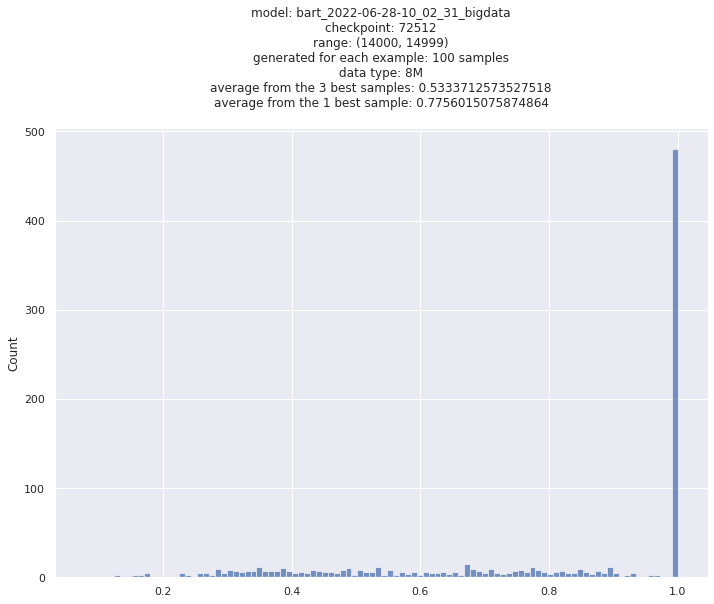

In [30]:
# %%time
from tqdm import tqdm
import seaborn as sns
def evaluate_model(data, data_range=range(100), num_generated=10, return_best=3, top_k=200, top_p=0.8, do_sample=True, num_beams=1, temperature=None):
    topNsum = 0
    top1sum = 0
    i = 0
    all_top1 = []
    for id_ in tqdm(data_range):
        simils = evaluate_datapoint(data[id_], num_generated=10, return_best=return_best, top_k=top_k, top_p=top_p, do_sample=do_sample, num_beams=num_beams, temperature=temperature, printing=False)
        topNsum += sum(simils)
        top1sum += simils[0]
        all_top1.append(simils[0])
    topNaverage = topNsum/(len(data_range)*return_best)
    top1average = top1sum/len(data_range)
    
    model_name = ''.join(model_path.split('/')[-3])
    output_text = \
          f"model: {model_name}\n" + \
          f"checkpoint: {checkpoint_num}\n" + \
          f"range: ({min(data_range)}, {max(data_range)})\n"+ \
          f"generated for each example: {num_generated} samples\n"+\
          f"data type: {data_type}\n" +\
          f"average from the {return_best} best samples: {topNaverage}\n"+\
          f"average from the 1 best sample: {top1average}\n"
    print( f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(all_top1, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    
    additional_info = "_unique"
    fig.savefig(f"figures/histo{additional_info}_{model_name}_check-{checkpoint_num}_{data_type}_gen{num_generated}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot


hist = evaluate_model(test_data, data_range=range(14000,15000), num_generated=100) # bbpe
# evaluate_model(test_data, data_range=range(15000, 16000), top_k=None, top_p=0.8) # non bbpe

### Visualization of molecules

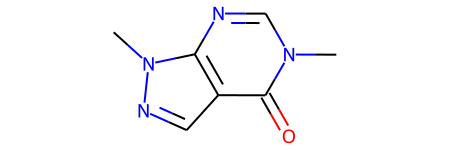

In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("O=c1n(C)cnc2c1cnn2C")
# Default
mol

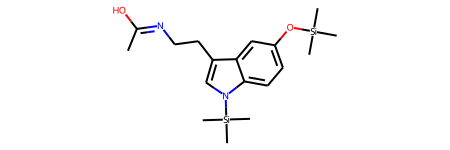

In [4]:
# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("C/C(O)=N\CCc1cn([Si](C)(C)C)c2ccc(O[Si](C)(C)C)cc12")
# Default
mol

<AxesSubplot:ylabel='Count'>

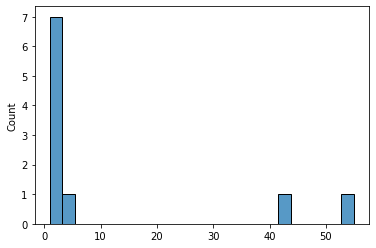

In [30]:
# test
import seaborn as sns

sns.histplot([1,2,3,4,55,43,2,2,1,1])